In [1]:
#!pip install pmdarima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [2]:
data = pd.read_csv('./data_preprocess_v3/googl.csv')

In [3]:
def adfuller_test(stocks):
    result=adfuller(stocks)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

# if result[1] <= 0.05:
#     print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
# else:
#     print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [4]:
adfuller_test(data['Close'])

ADF Test Statistic : -0.504323203892274
p-value : 0.8911700875772122
#Lags Used : 29
Number of Observations : 3902


In [24]:
## Differencing the data
data['Close First diff'] = data['Close'] - data['Close'].shift(1)
data['Close Seasonal diff']=data['Close']- data['Close'].shift(12)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close First diff,Close Seasonal diff
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000,NaN,NaN
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300,3.988991,NaN
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100,0.545544,NaN
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300,-2.267265,NaN
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600,0.565567,NaN


In [27]:
# Again testing if data is stationary, here p<0.05 ->reject null, data is stationary
adfuller_test(data['Close Seasonal diff'].dropna())

ADF Test Statistic : -9.923717029514894
p-value : 2.944580319356258e-17
#Lags Used : 31
Number of Observations : 3888


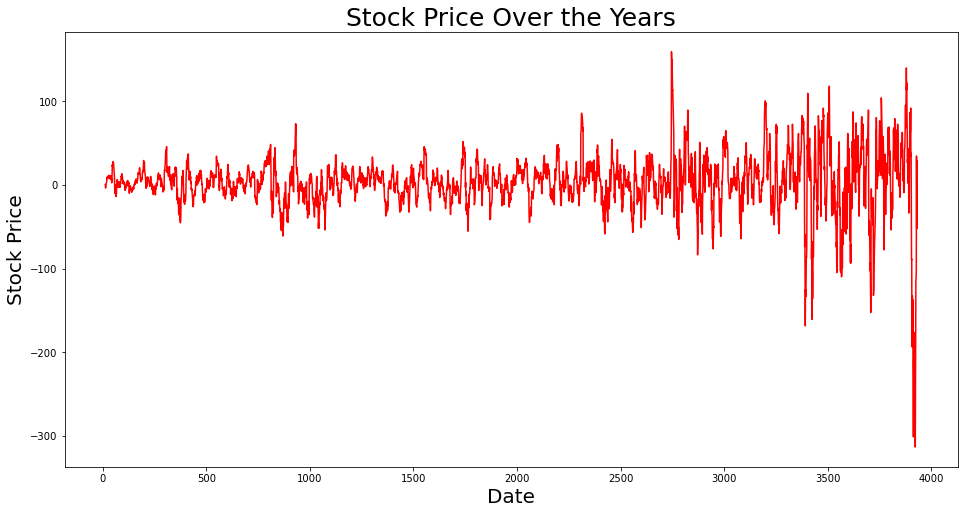

In [7]:
#plot seasonal diff
plt.figure(figsize=(16,8))
plt.plot(data['Close Seasonal diff'], label='Close Seasonal Diff.',color='r')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Over the Years',size=25);

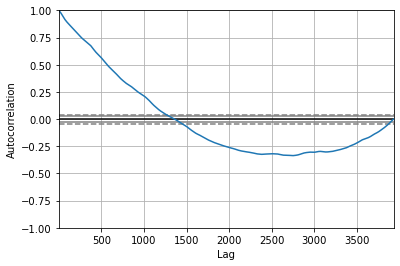

In [8]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Close'])
plt.show()

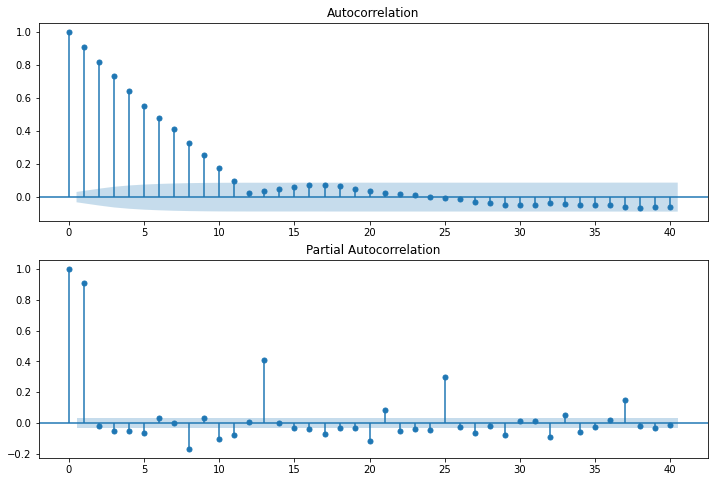

In [9]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Close Seasonal diff'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Close Seasonal diff'].dropna(),lags=40,ax=ax2)

No handles with labels found to put in legend.


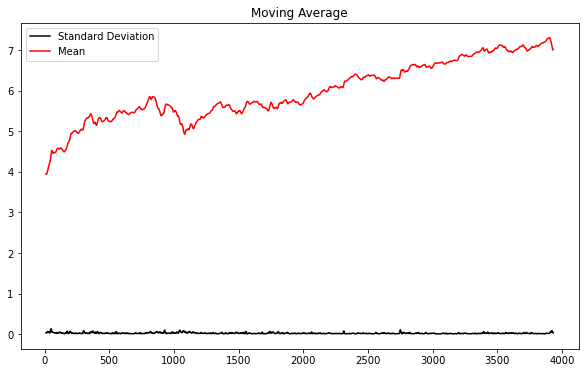

In [10]:
## removing trend element
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [28]:
df_log

0       3.916418
1       3.992851
2       4.002864
3       3.960575
4       3.971292
          ...   
3927    7.058689
3928    7.012350
3929    7.044303
3930    7.057855
3931    7.004973
Name: Close, Length: 3932, dtype: float64

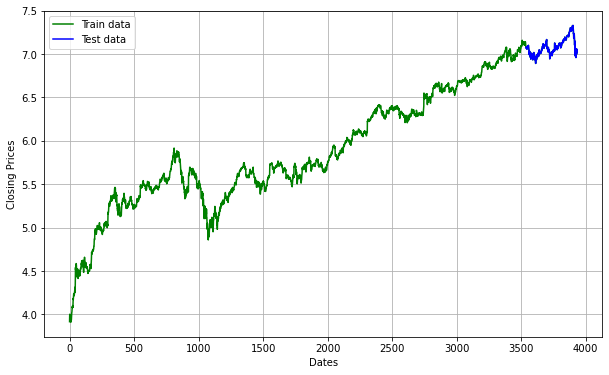

In [11]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22578.614, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-18013.492, Time=1.50 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=3.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-18010.135, Time=1.68 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.75 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.54 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-18002.098, Time=0.46 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 13.353 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3535
Model:               SARIMAX(1, 0, 1)   Log Likelihood                9009.746
Date:

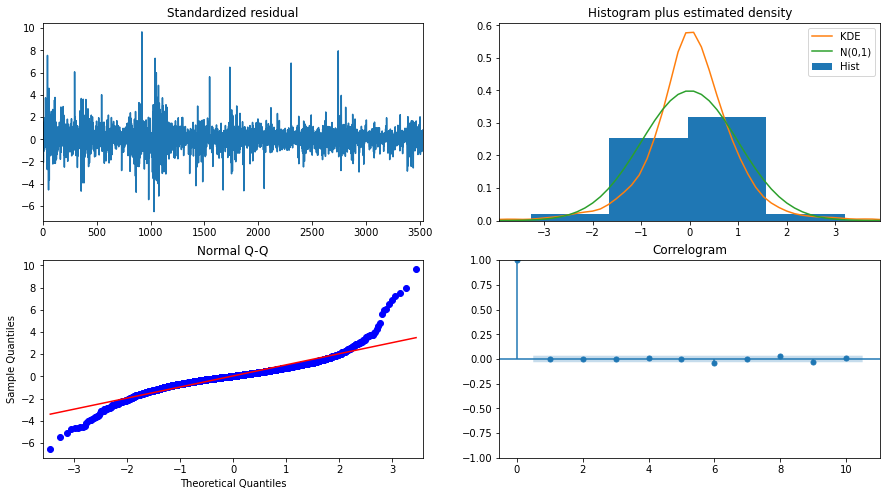

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [29]:
model = ARIMA(train_data, order=(10,0,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

C:\Users\sr_te\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 3535
Model:                    ARMA(10, 1)   Log Likelihood                9018.428
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 23 Oct 2021   AIC                         -18010.856
Time:                        23:00:51   BIC                         -17930.640
Sample:                             0   HQIC                        -17982.243
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.5668      1.296      4.297      0.000       3.027       8.106
ar.L1.Close      0.3828        nan        nan        nan         nan         nan
ar.L2.Close      0.6296        nan        na

C:\Users\sr_te\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [31]:
# Forecast
fc, se, conf = fitted.forecast(394, alpha=0.05)  # 95% conf

In [32]:
test_data

3538    7.071225
3539    7.069075
3540    7.081700
3541    7.066126
3542    7.075082
          ...   
3927    7.058689
3928    7.012350
3929    7.044303
3930    7.057855
3931    7.004973
Name: Close, Length: 394, dtype: float64

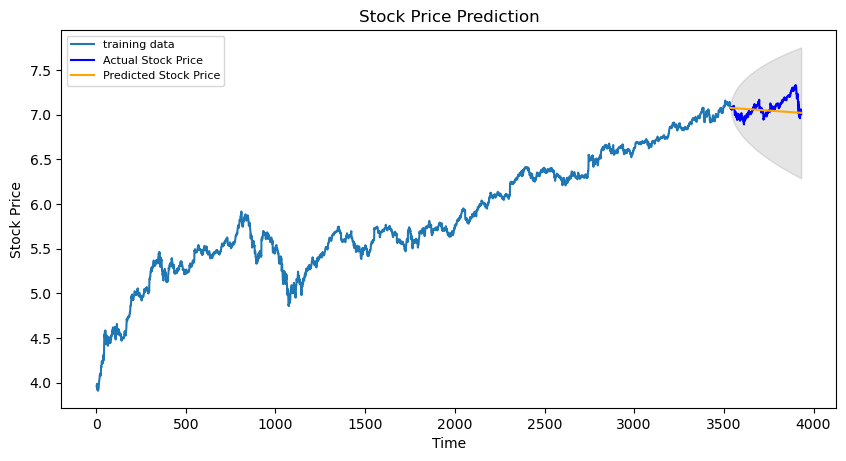

In [33]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [34]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.012720371035213228
MAE: 0.0856426021456385
RMSE: 0.11278462233484327
MAPE: 0.01199724516805007


In [35]:
def evaluate(test, label_test):
    predicted = test
    print("accuracy:", str(accuracy_score(label_test, predicted)))
    
    print("precision:", str(precision_score(label_test, predicted, average='weighted')))

    print("recall:", str(recall_score(label_test, predicted, average='weighted')))
   
    print("f1", str(f1_score(label_test, predicted, average='weighted')))
    
    print("metrics.roc_auc_score", str(roc_auc_score(label_test, predicted, average='weighted')))

    cm = confusion_matrix(label_test, predicted)
    f = sns.heatmap(cm, annot=True, fmt='d')
    
    classification = classification_report(label_test, predicted)
    print(classification)

In [36]:
fc_move = (ypred - test["Close (t-1)"])
fc_move = test_move.where(test_move < 0, 1).where(test_move >= 0, 0).astype(int)
test_move = 
evaluate(fc, test_data)

SyntaxError: invalid syntax (<ipython-input-36-47af51a37b83>, line 3)